In [55]:
# Minimum required
import dash
import dash_core_components as dcc
import pandas as pd
import plotly.express as px

In [56]:
# Additional stuff
import dash_html_components as html
import dash_table
from dash_table import DataTable, FormatTemplate
import pandas as pd
from dash.dependencies import Input, Output

In [57]:
import plotly.graph_objects as go
import json

## Tab 1 data preparation

In [58]:
data = pd.read_csv("data/A1a - KS2 standard RWM.csv")

In [59]:
tc_lookup = pd.read_csv("data/town_centre_ward_lookup.csv")

In [60]:
data = data.merge(tc_lookup, left_on = "Ward name", right_on = "Ward", how = "left").drop("Ward", axis = 1)

In [61]:
data['value_perc'] = (round(data['A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas']*100)).astype(str) + '%'

In [62]:
data.head()

,Unnamed: 0,Ward name,"A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas",Ward rank,Town centre,value_perc
0,0,Herne Hill,0.806719,10,Brixton,81.0%
1,1,Coldharbour,0.806719,10,Brixton,81.0%
2,2,Ferndale,0.806719,10,Brixton,81.0%
3,3,Brixton Hill,0.806719,10,Brixton,81.0%
4,4,Tulse Hill,0.806719,10,Brixton,81.0%


#### Tab 1 - Create a table

In [63]:
large_tb = data

In [64]:
perc_format = FormatTemplate.percentage(2)
perc_cols = ['A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas']
d_columns = [{'name':x, 'id':x} for x in large_tb.columns if x not in perc_cols]
d_columns += [
    {'name':'A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas', 'id':'A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas', 
    'type':'numeric', 
    'format':perc_format
     # Allow columns to be selected
    , 'selectable':True
    }#,
    #{'name':'Ward rank', 'id':'Ward rank', 
    #'type':'numeric', 
    #'format':money_format
     # Allow columns to be selected
    #, 'selectable':True
    #}
]

In [65]:
d_table = DataTable(
  			id='my_dt',
            columns=d_columns,
            data=large_tb.to_dict('records'),
            style_data={
                'whiteSpace': 'normal',
                'height': 'auto',
            },
            style_header={
                'whiteSpace': 'normal',
                'height': 'auto',
            },
            cell_selectable=True,
            sort_action='native',
  			# Make single columns selectable
            column_selectable='single',
            row_selectable='multi',
            filter_action='native',
            page_action='native',
            page_current=0,
            page_size=10
            )

#### Tab 1 - create dropdown and categories for dropdown

In [66]:
major_categories = list(data['Town centre'].dropna().unique())
minor_categories = list(data['Ward name'].unique())

## Tab 2 data preparation

In [67]:
lambeth_pred_data = pd.read_csv("data/pred_pop_2018_lam_group.csv")

In [68]:
lambeth_pred_data_m = lambeth_pred_data.drop('age',axis=1).melt(id_vars = "ward_name").rename(columns={"variable":"year","value":"pop"})

In [69]:
minor_categories_2 = list(lambeth_pred_data['ward_name'].unique())

#### Create a map

In [70]:
#from urllib.request import urlopen
with open('data/lambeth_old_wards_wgs84.geojson') as response:
    lambeth_ward_json = json.load(response)

#lambeth_ward_json["features"][0]

In [71]:
data.columns

Index(['Unnamed: 0', 'Ward name',
       'A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas',
       'Ward rank', 'Town centre', 'value_perc'],
      dtype='object')

In [73]:
data['WD13NM'] = data['Ward name']

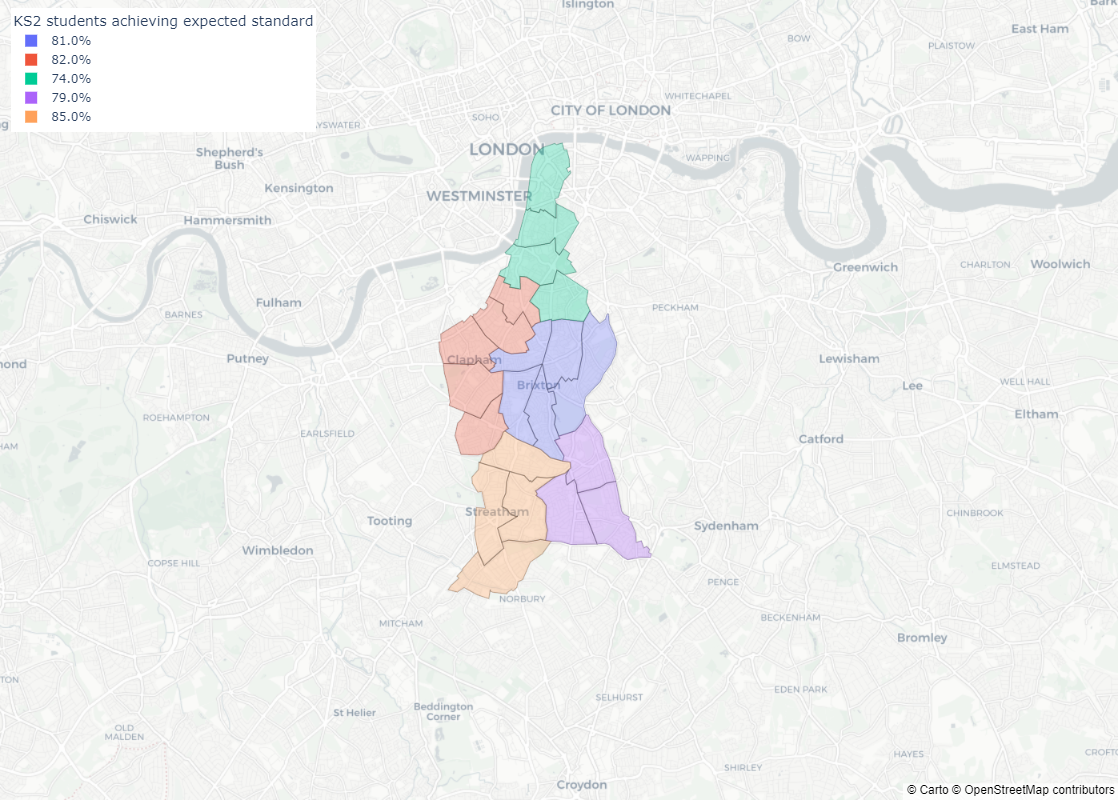

In [91]:
fig = px.choropleth_mapbox(data, geojson=lambeth_ward_json, locations='WD13NM', color='value_perc',
                           color_continuous_scale="Viridis", featureidkey="properties.WD13NM",
                           range_color=(0, 12),
                           mapbox_style= "carto-positron", # "open-street-map",
                           center = {"lat": 51.4535, "lon": -0.11},
                           zoom=11,
                           #scope="europe",
                           labels={'value_perc':'KS2 students achieving expected standard'},
                           custom_data=["WD13NM"],
                           opacity=0.3
                          )

fig.update_layout(height=800, 
                  margin={"r":0,"t":0,"l":0,"b":0},
                  legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01
                    )
                 )

## Create the Dash app

In [75]:
app = dash.Dash(__name__)
server = app.server

server = flask.Flask(__name__)
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP], server=server)

# Setup the layout

In [76]:
# Set up the layout with a single graph
app.layout = html.Div([
    
    dcc.Tabs([
        dcc.Tab(label='Tab one', children=[
        # Title and break
        html.H1('KS2 students achieving expected standard in\nreading, writing, and maths'),
        html.Br(),
        
        # Dropdown and title
        html.Div( 
            children=[
                html.H3('Town centre selection'),
            
                dcc.Dropdown(id='major_cat_dd',
                    options=[{'label':category, 'value':category} for category in major_categories], multi = True),
        #    
                html.Br(),
            
                html.H3('Ward selection'),
            
                dcc.Dropdown(id='minor_cat_dd',
                    options=[{'label':categori, 'value':categori} for categori in minor_categories], multi = True)
               
            ],
        style={'width':'350px', 'display':'block', 'vertical-align':'top', 'border':'1px solid black', 'padding':'10px', 'margin':'auto'}
        ),
    
        html.Div(
            children=[
            # Bar graph
            dcc.Graph(
              id='my-bar-graph')#,
              # Insert the bar graph
              #figure=bar_fig)
            ]    
        ,style={'text-align':'center', 'display':'inline-block', 'width':'100%'} 
        ),
    
        html.Div(
            d_table, 
            style={'width':'80%', 'height':'200px', 'margin':'10px auto', 'padding-right':'30px','display':'inline'}),
        
        
        #### Map
        html.Div( 
            dcc.Graph(
              id='my-map', figure=fig),
              style={'width':'800px', 'margin':'auto', 'display':'inline'}
        
        ),
            
        ]),
        
        
        dcc.Tab(label='Tab two', children=[
        html.H1('Welcome to tab 2'),
            
        
            
        html.Div( 
            children=[
                 html.H3('Ward selection'),
                
                 dcc.Dropdown(id='minor_cat_dd_2',
                 options=[{'label':categori, 'value':categori} for categori in minor_categories], multi = True)
               
            ],
        style={'width':'350px', 'display':'block', 'vertical-align':'top', 'border':'1px solid black', 'padding':'10px', 'margin':'auto'}
        ),
            
        html.Div(
            children=[
            # Bar graph
            dcc.Graph(
              id='my-line-graph')#,
              # Insert the bar graph
              #figure=bar_fig)
            ]    
        ,style={'text-align':'center', 'display':'inline-block', 'width':'100%'} 
        )
        ])
        
    ])
])

## Tab 1 callbacks

#### Callback for category filter interaction with graph

In [77]:
@app.callback(
   Output('my-bar-graph', 'figure'),
   #Output('chosen_major_cat_title', 'children'),
   Input('major_cat_dd', 'value'),
   Input('minor_cat_dd', 'value'))

def update_bar(major_cat_dd, minor_cat_dd):
    major_cat_title = 'All'
    data_bar = data.copy()
    
    if major_cat_dd:
        major_cat_title = major_cat_dd
        data_bar = data_bar[data_bar['Town centre'].isin(major_cat_dd)]
        
    if minor_cat_dd:
        data_bar = data_bar[data_bar['Ward name'].isin(minor_cat_dd)]
        
    #data_bar = data_bar.groupby('Year-Month')['OrderValue'].agg('sum').reset_index(name='Total Sales ($)')
    
    bar_graph = px.bar(data_bar, x='Ward name', 
                       y='A1a - % KS2 students achieving expected standard in reading, writing, and maths in town centre areas',
    height=600, # width=1000, , 
    title=f'% KS2 students achieving expected standard in<br>reading, writing, and maths in town centre areas: {major_cat_title}', 
    custom_data=['Town centre', "Ward name", "value_perc"], color='Ward name', template='simple_white', text='value_perc'
                  )# text_auto=True,
    
    # Bar appearance
    bar_graph.update_traces(marker_line_color='rgb(8,48,107)',# marker_color='rgb(158,202,225)', 
    marker_line_width=1.5, opacity=0.6)
    
    # Text label appearance
    bar_graph.update_traces(textfont_size=12,
                        textangle=0,
                        textposition="outside"
                       )        

    # Title options  
    bar_graph.update_layout(#{title:{'x':0.5}},
                        title={
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                        xaxis_title=None,
                        yaxis_title="A1a - % KS2 students achieving expected standard<br>in reading, writing, and maths (%)")

    # xaxis label options
    bar_graph.update_layout(
                        xaxis_tickangle=-45
    )

    # hover popup options
    bar_graph.update_traces(
        hovertemplate="<br>".join([
            "Ward: %{customdata[1]}",
            "Town centre: %{customdata[0]}",
            "Value: %{customdata[2]}"]
    ))
    
    return bar_graph

#### Callback - major category dropdown interaction with minor category dropdown

In [78]:
@app.callback(
   Output('minor_cat_dd', 'options'),
   #Output('chosen_major_cat_title', 'children'),
   Input('major_cat_dd', 'value'))

def update_dd(major_cat_dd):
    
    major_minor = data[['Town centre', 'Ward name']].drop_duplicates()
    
    minor_options = [dict(label=x, value=x) for x in major_minor['Ward name'].values.tolist()]
     
    if major_cat_dd:        
        relevant_minor = major_minor[major_minor['Town centre'].isin(major_cat_dd)]['Ward name'].values.tolist()
        minor_options = [dict(label=x, value=x) for x in relevant_minor]

    return minor_options#, major_cat_title

# Tab 2 callbacks

In [79]:
@app.callback(
   Output('my-line-graph', 'figure'),
   #Output('chosen_major_cat_title', 'children'),
   #Input('major_cat_dd', 'value'),
   Input('minor_cat_dd_2', 'value'))

def update_line(minor_cat_dd_2):
    major_cat_title = 'All'
    data_line = lambeth_pred_data_m.copy()
    
    #if major_cat_dd:
     #   major_cat_title = major_cat_dd
     #   data_line = data_line[data_line['Town centre'].isin(major_cat_dd)]
        
    if minor_cat_dd_2:
        major_cat_title = minor_cat_dd_2
        data_line = data_line[data_line['ward_name'].isin(minor_cat_dd_2)]
        
    #data_line = data_line.groupby('Year-Month')['OrderValue'].agg('sum').reset_index(name='Total Sales ($)')
    
    line_graph = px.line(data_line, x='year', y='pop',
    height=600, # width=1000, , 
    title=f'Predicted population in areas: {major_cat_title}', 
    custom_data=['ward_name','pop'], color='ward_name', template='simple_white'#, text='pop'
                  )# text_auto=True,
    
    # Bar appearance
    line_graph.update_traces(marker_line_color='rgb(8,48,107)',# marker_color='rgb(158,202,225)', 
    marker_line_width=1.5, opacity=0.6)
    
    # Text label appearance
    line_graph.update_traces(textfont_size=12,
                        #textangle=0,
                        textposition="top center"
                       )        

    # Title options  
    line_graph.update_layout(#{title:{'x':0.5}},
                        title={
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                        xaxis_title=None,
                        yaxis_title="Population")

    # xaxis label options
    line_graph.update_layout(
                        xaxis_tickangle=-45
    )

    # hover popup options
    line_graph.update_traces(
        hovertemplate="<br>".join([
            "Ward: %{customdata[0]}",
            "Value: %{customdata[1]}"]
    ))
    
    return line_graph

## Run the app

In [80]:
# Set the app to run in development mode
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [81]:
# Following is if you need to debug
# %tb